In [1]:

import pandas as pd
import os
import re
from pathlib import Path
from typing import Union

## Scenarios to analyse:
- ATCO006 - Scenario 1: 
    - Start: 1756973880000 (2025-09-04 08:26:40 UTC)
    - Stop: 1756974060000 (2025-09-04 08:29:40 UTC)
- ATCO001 - Scenario 3: 
    - Start: 1758890880000 (2025-09-26 12:48:00 UTC)
    - Stop: 1758891060000 (2025-09-26 12:51:00 UTC)
- ATCO007 - Scenario 2: 
    - Start: 1758091320000 (2025-09-17 06:26:40 UTC)
    - Stop: 1758091500000 (2025-09-17 06:29:40 UTC)

****
# Reproducing data loading pipeline (load_and_process_et)
****

WARNING: Reconstructing the chunks (windows) from scratch by just extracting the part that we want to analyse in the data is a bad idea because some task might began or end before or after the part we have doenloaded. Hw have to find a way to either:
- produce the prediction for the whole scenatio and then only select the part we want to display
- Load the chunks corresponding to the part we want to analyse only corresponding to the task we want to analyse. 

NB: The chunks per se are not saved. Only the training and test datasets. Either in those datasets the epoch is available to select those, or we have to use solution 1. 

NB: Solution 1 is longer but more straightforward.

In [180]:
from utils.task_data_io import PARQUET_ET_NAME, list_parquet_files
from utils.data_processing_gaze_data import EyeTrackingProcessor

# Loading full scenario because the prediction has to be made on the whole scenario to be relevant
def load_scenario(
    root: Union[str, Path],
    participant_id: Union[str, int],
    scenario_id: Union[str, int],
    # epoch_start: int,
    # epoch_end: int,
    timestamp_col: str = "epoch_ms", #(equal to epoch_ms_sync because preprocessed before)
):
    """
    Load one participant + scenario and filter rows between two epoch timestamps (epoch_ms).
    """
    
    # if epoch_end < epoch_start:
    #     raise ValueError("epoch_end must be >= epoch_start")
    
    # Find eye tracking and asd file names
    et_file_index, asd_file_index = list_parquet_files(root, participants=participant_id, scenarios=scenario_id)
    
    # Loading eye tracking data between epoch
    item = et_file_index[0]
    p_et = item["path"]
    df_et = pd.read_parquet(p_et)
    
    df_et = df_et.copy()
    # df_et= df_et[df_et[timestamp_col].between(epoch_start, epoch_end)]
    df_et["participant_id"] = str(item["participant_id"])
    df_et["scenario_id"] = str(item["scenario_id"])
    
    #loading asd events 
    item = asd_file_index[0]
    p_asd = item["path"]
    df_asd = pd.read_parquet(p_asd)
    
    df_asd = df_asd.copy()
    # df_asd= df_asd[df_asd["epoch_ms"].between(epoch_start, epoch_end)]
    df_asd["participant_id"] = str(item["participant_id"])
    df_asd["scenario_id"] = str(item["scenario_id"])

    return df_et, df_asd

store_dir = "/store/kruu/eye_tracking"
data_dir = os.path.join(store_dir, "training_data")    
df_et, df_asd = load_scenario(root = data_dir, 
                             participant_id = ["003"],
                             scenario_id = ["3"],)

In [181]:
# Task map defined when loading all data before training. Should keep the same in inference (could be useful to actually save it in the logs)

task_map = {'Aircraft requests': 'Task 0',
 'Assume': 'Task 1',
 'Conflict resolution': 'Task 2',
 'Entry conditions': 'Task 3',
 'Entry conflict resolution': 'Task 4',
 'Entry coordination': 'Task 5',
 'Exit conditions': 'Task 6',
 'Exit conflict resolution': 'Task 7',
 'Exit coordination': 'Task 8',
 'Non-conformance resolution': 'Task 9',
 'QoS': 'Task 10',
 'Return to route': 'Task 11',
 'Transfer': 'Task 12',
 'Zone conflict': 'Task 13'}

In [182]:
# Mimic the output after function "load data"

def apply_existing_task_map(
    df: pd.DataFrame,
    task_map: dict[str, str],
    event_col: str = "Event",
) -> pd.DataFrame:
    """
    Apply an existing task_map to a single dataframe.
    
    Converts:
        'Assume - start' → 'Task 1'
        'Assume - end'   → 'Task 1 end'
    
    Leaves unknown or non-task events unchanged.
    """

    df = df.copy()

    def map_event(event):
        if not isinstance(event, str) or " - " not in event:
            return event

        root, suffix = event.split(" - ", maxsplit=1)

        task_label = task_map.get(root)
        if task_label:
            if suffix.strip().lower() == "start":
                return task_label
            elif suffix.strip().lower() == "end":
                return f"{task_label} end"

        # If root not in task_map, return original
        return event

    df[event_col] = df[event_col].apply(map_event)

    return df

df_et_task = apply_existing_task_map(df_et, task_map)

In [183]:
columns = ['Recording timestamp [ms]', 'epoch_ms', 'Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Event']

# Calculate the blinks
processor = EyeTrackingProcessor()
df_et_task_with_blinks, blink_summaries = processor.detect_blinks_in_streams([df_et_task])

# Get the multiscales windows: put the same parameters as training
chunks_et = processor.get_multiscale_window_chunks(
            df_et_task_with_blinks,
            features=columns + ["Blink", "Loss of Attention"],
            window_short_ms = 5000,
            window_mid_ms = 10000,
            window_long_ms = 25000,
            task_margin_ms=2000,
            step_ms=3000,
            filter_outliers=True,
        )

# NB: don't drop nans because we don't need to clean during inference

Finding tasks for participant 003 Scenario 3


****
# Feature extraction
****

In [184]:
# handmade features extraction
from tqdm import tqdm
from utils.data_processing_gaze_data import GazeMetricsProcessor
from utils.data_processing_mouse_data import MouseMetricsProcessor
from utils.data_processing_asd_events import ASDEventsMetricsProcessor

df_asd = df_asd.sort_values("epoch_ms").set_index("epoch_ms")

window_keys = ("short", "mid", "long")
rows = []

for uid, windows in tqdm(chunks_et.items()):
    
    row = {"id": uid}
    row["participant_id"] = windows["short"]["Participant name"].iloc[0]
    row["Task_id"] = windows["short"]["Task_id"].iloc[0]
        
    for wname in window_keys:
        chunk = windows[wname]
        min_epoch = chunk["epoch_ms"].min()
        max_epoch = chunk["epoch_ms"].max()
        
        window_asd = df_asd.loc[min_epoch:max_epoch].reset_index()
        
        # Gaze metrics
        gaze_processor = GazeMetricsProcessor(chunk, timestamp_unit="ms")
        gaze_metrics = gaze_processor.compute_all_metrics()   
        prefixed_gaze = {f"{wname}_{k}": v for k, v in gaze_metrics.items()}
        row.update(prefixed_gaze)
        
        # Mouse metrics
        mouse_processor = MouseMetricsProcessor(window_asd, resample=False)
        mouse_metrics = mouse_processor.compute_all_metrics()   
        prefixed_mouse = {f"{wname}_{k}": v for k, v in mouse_metrics.items()}
        row.update(prefixed_mouse)
        
        # ASD events metrics
        asd_processor = ASDEventsMetricsProcessor(window_asd)
        asd_metrics = asd_processor.compute_all_metrics()   
        prefixed_asd = {f"{wname}_{k}": v.iat[0] for k, v in asd_metrics.items()}
        row.update(prefixed_asd)
    
    rows.append(row)

metrics_df = pd.DataFrame(rows)

100%|██████████| 1234/1234 [05:41<00:00,  3.62it/s]


In [185]:
import joblib
from trainings._01_xgboost_hierarchical_training import extract_tsfresh_features_from_multiscale_chunks

def tsfresh_for_model_features(
    multiscale_chunks: dict[str, dict[str, pd.DataFrame]],
    columns_to_extract: list[str],
    n_jobs: int = 50,
) -> pd.DataFrame:
    """
    1) Computes TSFresh features WITHOUT thresholding (keeps everything produced)
    Returns a dataframe with columns: ['id', <tsfresh cols that model expects>]
    """

    # ---- compute ALL tsfresh features for all scales (no thresholding) ----
    tsfresh_df = extract_tsfresh_features_from_multiscale_chunks(
        multiscale_chunks=multiscale_chunks,
        columns_to_extract=columns_to_extract,
        pval_threshold=1,   # IMPORTANT: no selection at inference
        n_jobs=n_jobs,
    )

    return tsfresh_df

tsfresh_data = tsfresh_for_model_features(
    multiscale_chunks=chunks_et,
    columns_to_extract=['Gaze point X [DACS px]', 'Gaze point Y [DACS px]'],
)

Extracting TSFresh features...


Feature Extraction: 100%|██████████| 247/247 [00:00<00:00, 317.19it/s]


Extracting TSFresh features...


Feature Extraction: 100%|██████████| 247/247 [00:00<00:00, 265.40it/s]


Extracting TSFresh features...


Feature Extraction: 100%|██████████| 247/247 [00:01<00:00, 198.64it/s]


In [186]:
from trainings._01_xgboost_hierarchical_training import build_xy

# Merging data
merged_data = metrics_df.merge(tsfresh_data, on="id", how="inner")

# Building XGBoost input df and sanitzing column names (within build_xy)
# We have the ground truth here if needed. 
X, y_tasks, y_active, _ = build_xy(merged_data, [])

# Drop features that are not in model features (because of pval thresholding in tsfresh)
bundle_A = joblib.load("trainings/logs/xgboost_hierarchical_v5/best_model_stageA.pkl")
model_A = bundle_A["model"]
expected = list(model_A.feature_names_in_)
X = X.reindex(columns=expected)

# Ensure numeric
for c in X.columns:
    if not pd.api.types.is_numeric_dtype(X[c]):
        X[c] = pd.to_numeric(X[c], errors="coerce").fillna(0.0)

In [187]:
X.head(10)

,short_Fixation_Count,short_Total_Fixation_Duration_(s),short_Avg_Fixation_Duration_(s),short_Saccade_Count,short_Avg_Saccade_Amplitude_(px),short_Avg_Saccade_Velocity_(px/s),short_Avg_Gaze_Velocity_(px/s),short_Avg_Gaze_Acceleration_(px/s²),short_Blink_Rate_(blinks/s),short_Gaze_Dispersion_(area_px²),...,long_Gaze_point_Y__DACS_px___mean,long_Gaze_point_X__DACS_px___mean,long_Gaze_point_Y__DACS_px___sum_values,long_Gaze_point_X__DACS_px___sum_values,long_Gaze_point_X__DACS_px___absolute_maximum,long_Gaze_point_X__DACS_px___maximum,long_Gaze_point_Y__DACS_px___standard_deviation,long_Gaze_point_Y__DACS_px___variance,long_Gaze_point_Y__DACS_px___median,long_Gaze_point_X__DACS_px___root_mean_square
0,0.0,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,130.234421,NaN,...,623.558411,1760.959106,1996634.0,5638591.0,2357.0,2357.0,318.370361,101359.679688,492.0,1855.797729
1,2.0,0.432,0.216000,0.0,0.000000,0.000000,587.500610,-85287.085938,72.530556,1357746.0,...,617.599792,1794.682617,2057225.0,5978088.0,2357.0,2357.0,326.685486,106723.406250,485.0,1855.739258
2,3.0,0.568,0.189333,0.0,0.000000,0.000000,524.734253,-58015.679688,92.255356,1884785.0,...,645.993225,1851.011841,2185395.0,6261973.0,2469.0,2469.0,363.109406,131848.453125,490.0,1920.039307
3,0.0,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,145.261475,NaN,...,630.559204,1685.251465,2104176.0,5623684.0,2469.0,2469.0,427.613739,182853.500000,409.0,1758.303223
4,0.0,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,124.223602,NaN,...,726.237122,1808.383423,2422727.0,6032767.0,2469.0,2469.0,464.848267,216083.921875,409.0,1885.820801
5,0.0,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,120.216393,NaN,...,889.981140,1710.318237,2969867.0,5707332.0,2469.0,2469.0,410.722443,168692.921875,1131.0,1860.527832
6,5.0,0.872,0.174400,0.0,0.000000,0.000000,242.974625,846.023621,95.371666,64260.0,...,904.407227,1799.621460,3018007.0,6005337.0,2469.0,2469.0,421.090240,177317.000000,1283.0,1931.214111
7,4.0,0.672,0.168000,0.0,0.000000,0.000000,222.524170,636.874329,99.979965,64260.0,...,897.502869,1881.611328,2994967.0,6278937.0,2469.0,2469.0,428.436646,183557.968750,1283.0,1988.156006
8,0.0,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,120.216393,NaN,...,894.064392,1971.915649,2958459.0,6525069.0,2469.0,2469.0,435.748962,189877.156250,1295.0,2050.154297
9,3.0,0.816,0.272000,1.0,230.462585,7366.645508,325.416809,-5549.623535,93.349358,120720.0,...,916.273804,2083.906738,2941239.0,6689341.0,2469.0,2469.0,425.683044,181206.046875,1295.0,2124.211426


In [188]:
# TESTING FEATURES MATCHING

import numpy as np

expected = np.array(model_A.feature_names_in_, dtype=str)
got      = np.array(X.columns, dtype=str)

missing_in_X = sorted(set(expected) - set(got))
extra_in_X   = sorted(set(got) - set(expected))

print(f"Expected features (model): {len(expected)}")
print(f"Got features (X):          {len(got)}")
print(f"Missing in X:              {len(missing_in_X)}")
print(f"Extra in X:                {len(extra_in_X)}")

if missing_in_X:
    print("\n--- First 50 missing ---")
    print("\n".join(missing_in_X[:50]))

if extra_in_X:
    print("\n--- First 50 extra ---")
    print("\n".join(extra_in_X[:50]))

# Optional: check ordering of common columns
common = [c for c in expected if c in set(got)]
wrong_order = sum(got.tolist().index(c) != i for i, c in enumerate(common))
print(f"\nCommon features:           {len(common)}")
print(f"Common but wrong position: {wrong_order} (relative to model order)")

Expected features (model): 459
Got features (X):          459
Missing in X:              0
Extra in X:                0

Common features:           459
Common but wrong position: 0 (relative to model order)


****
# Model inference
****

In [189]:
import numpy as np
import joblib
from trainings._01_xgboost_hierarchical_training import build_xy

def infer_hierarchical_smoothed(
  X: pd.DataFrame,
  model_dir: Union[str, Path],
  idle_label: int = -1,          # same as training
  alpha_B: float = 0.6,         # same as training report (though it could be changed)
  ) -> tuple[pd.Series, pd.DataFrame]:
  """
  Returns:
    - yhat: predicted class label per row (index aligned to xgboost_data)
    - P:    combined (smoothed) class probabilities dataframe
  """

  model_dir = Path(model_dir)

  # Load model stages
  bundle_A = joblib.load(model_dir / "best_model_stageA.pkl")
  model_A = bundle_A["model"]
  threshold_A = bundle_A.get("threshold", None)

  bundle_B = joblib.load(model_dir / "best_model_stageB.pkl")
  model_B = bundle_B["model"]

  # Stage A probabilities (Active VS idle)
  pA = pd.Series(model_A.predict_proba(X)[:, 1], index=X.index, name="p_active")

  # Stage B probabilities (Task id)
  prob_B = model_B.predict_proba(X)
  classes_B = model_B.classes_  # labels for columns in prob_B
  active_classes = np.array(classes_B)
  pB = pd.DataFrame(prob_B, index=X.index, columns=active_classes)
  
  # smooth Stage B (EMA over time)
  pB_smooth = pB.ewm(alpha=alpha_B, adjust=False).mean()
  # We will need to adapt the smoothing when predicting in real-time. We will need to store the previous predictions
  # Here previous predictions are already stored as we predict a batch on consecutive times at once. 

  # rebuild combined probabilities over ALL classes (include IDLE)
  all_cols = [idle_label] + list(active_classes)
  P = pd.DataFrame(0.0, index=X.index, columns=all_cols)

  P[idle_label] = 1.0 - pA.values
  for c in active_classes:
      P[c] = pA.values * pB_smooth[c].values

  # (optional) renormalize to sum to 1
  row_sum = P.sum(axis=1).replace(0.0, 1.0)
  P = P.div(row_sum, axis=0)

  # final prediction
  yhat = P.idxmax(axis=1)

  return yhat, P

In [190]:
y_hat, P = infer_hierarchical_smoothed(
    X=X,
    model_dir="trainings/logs/xgboost_hierarchical_v5",
    idle_label=-1,
    alpha_B=0.6,
)

In [191]:
ids = []
epochs = []
for _, dic in chunks_et.items(): 
    ids.append(dic["short"]["id"].min())
    epochs.append(dic["short"]["epoch_ms"].max().item())

out = pd.DataFrame({"id": ids, "prediction_epoch_ms": epochs})

out["pred_task"] = np.asarray(y_hat)
out["true_task"] = np.asarray(y_tasks)
out["pred_proba"] = P.to_numpy().max(axis=1)


In [195]:
out.query("1758705557261 <= prediction_epoch_ms <= 1758705674282")

,id,prediction_epoch_ms,pred_task,true_task,pred_proba
1007,003_3_8_5,1758705557261,8,8,0.452041
1008,003_3_8_6,1758705560261,8,8,0.644427
1009,003_3_8_7,1758705563262,8,8,0.772642
1010,003_3_8_8,1758705566263,8,8,0.578119
1011,003_3_8_9,1758705569263,8,8,0.617782
1012,003_3_8_10,1758705572263,8,8,0.572570
1013,003_3_8_11,1758705575263,8,8,0.595620
1014,003_3_-1_682,1758705578264,-1,-1,0.331468
1015,003_3_-1_683,1758705581265,13,-1,0.246872
1016,003_3_-1_684,1758705584265,6,-1,0.388490


/tmp/ipykernel_4103099/3382965302.py:77: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  t_num = mdates.date2num(d["_dt_utc"].dt.to_pydatetime())


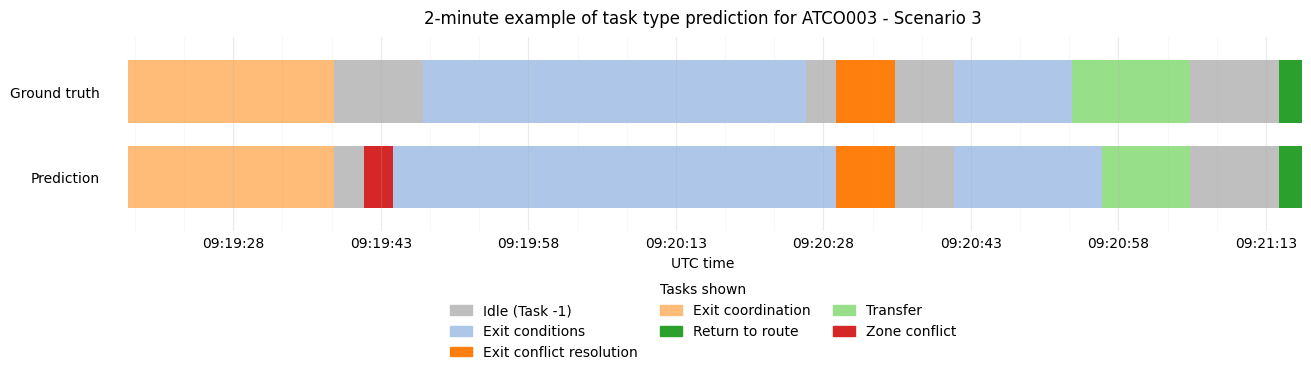

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

_id_to_label = {-1: "Idle (Task -1)"}
for name, task_str in task_map.items():
    n = int(task_str.split()[-1])
    _id_to_label[n] = f"{name}"


def _build_segments(t_num: np.ndarray, y: np.ndarray):
    """
    Convert per-sample discrete labels into contiguous time segments.

    Inputs:
      t_num: matplotlib date numbers (float days)
      y: task ids
    Output:
      list of (start_num, duration_num, task_id)
    """
    if len(t_num) == 0:
        return []

    order = np.argsort(t_num)
    t_num = t_num[order]
    y = y[order]

    segs = []
    start = t_num[0]
    cur = y[0]

    for i in range(1, len(t_num)):
        if y[i] != cur:
            end = t_num[i]  # segment ends at next timestamp
            segs.append((start, max(0.0, end - start), cur))
            start = t_num[i]
            cur = y[i]

    # Last segment duration: median step (in date-number units), else 0
    if len(t_num) >= 2:
        step = float(np.median(np.diff(t_num)))
    else:
        step = 0.0
    segs.append((start, step, cur))

    return segs


def plot_dual_task_timeline_utc(
    df: pd.DataFrame,
    time_col: str = "prediction_epoch_ms",
    true_col: str = "true_task",
    pred_col: str = "pred_task",
    title: str = "Example excerpt: Ground truth vs prediction",
    figsize=(13, 3.6),
    legend_max_items: int = 14,
):
    """
    Dual strip timeline:
      - Top strip: Ground truth
      - Bottom strip: Prediction
    X-axis: UTC time (from prediction_epoch_ms), formatted as HH:MM:SS.

    Returns: (fig, ax)
    """
    # --- Prep ---
    d = df[[time_col, true_col, pred_col]].copy()
    d = d.dropna().sort_values(time_col)

    # Convert epoch ms -> UTC datetime
    dt = pd.to_datetime(d[time_col].astype("int64"), unit="ms", utc=True)
    d["_dt_utc"] = dt

    # Matplotlib date numbers for broken_barh
    t_num = mdates.date2num(d["_dt_utc"].dt.to_pydatetime())

    y_true = d[true_col].astype(int).to_numpy()
    y_pred = d[pred_col].astype(int).to_numpy()

    # Tasks present in this excerpt (for legend and colors)
    present_ids = sorted(set(y_true.tolist()) | set(y_pred.tolist()))

    # --- Colors (clean & consistent) ---
    # Use tab20 for variety, but force IDLE to a neutral gray.
    base_cmap = plt.get_cmap("tab20", 20)

    # deterministic ordering for colors: IDLE first, then 0..13
    ordered_ids = [-1] + [i for i in range(0, 14) if i in present_ids]
    # add any other unexpected ids at the end
    ordered_ids += [i for i in present_ids if i not in ordered_ids]

    task_to_color = {}
    for i, tid in enumerate(ordered_ids):
        if tid == -1:
            task_to_color[tid] = (0.75, 0.75, 0.75, 1.0)  # light gray
        else:
            task_to_color[tid] = base_cmap(i % 20)

    # --- Segments ---
    seg_true = _build_segments(t_num, y_true)
    seg_pred = _build_segments(t_num, y_pred)

    # --- Figure styling ---
    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    # Strip geometry
    strip_h = 0.32
    true_ymin = 0.56
    pred_ymin = 0.12

    # Draw the strips
    for start, dur, tid in seg_true:
        ax.broken_barh(
            [(start, dur)],
            (true_ymin, strip_h),
            facecolors=task_to_color.get(tid, base_cmap(0)),
            edgecolors="none",
        )

    for start, dur, tid in seg_pred:
        ax.broken_barh(
            [(start, dur)],
            (pred_ymin, strip_h),
            facecolors=task_to_color.get(tid, base_cmap(0)),
            edgecolors="none",
        )

    # Labels
    ax.set_ylim(0, 1.0)
    ax.set_yticks([true_ymin + strip_h / 2, pred_ymin + strip_h / 2])
    ax.set_yticklabels(["Ground truth", "Prediction"])

    ax.set_title(title, pad=10)
    ax.set_xlabel("UTC time")
    
    # X axis formatting: fixed 15-second ticks, full HH:MM:SS
    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=15))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.xaxis.set_minor_locator(mdates.SecondLocator(interval=5))
    plt.setp(ax.get_xticklabels(), rotation=0, ha='center')
    ax.grid(True, axis="x", which="major", alpha=0.25)
    ax.grid(True, axis="x", which="minor", alpha=0.08)

    # Make x-lims slightly padded
    if len(t_num) > 0:
        pad = (t_num.max() - t_num.min()) * 0.02 if t_num.max() > t_num.min() else 1 / 86400
        ax.set_xlim(t_num.min() - pad, t_num.max() + pad)

    # Subtle vertical grid to help reading time
    ax.grid(True, axis="x", linewidth=0.8, alpha=0.25)
    ax.grid(False, axis="y")

    # Remove spines for a cleaner look
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.tick_params(axis="both", which="both", length=0)  # no tick marks

    # --- Legend (use your mapping names + ids) ---
    # Keep legend compact: include only tasks present, ordered nicely.
    legend_ids = [-1] + [i for i in range(0, 14) if i in present_ids]
    legend_ids = [i for i in legend_ids if i in present_ids]

    # cap if needed (usually 15 max including IDLE)
    legend_ids = legend_ids[:legend_max_items]

    handles = []
    for tid in legend_ids:
        label = _id_to_label.get(tid, f"Unknown ")
        handles.append(mpatches.Patch(color=task_to_color[tid], label=label))

    ax.legend(
        handles=handles,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.20),
        ncol=3,
        frameon=False,
        title="Tasks shown",
        handlelength=1.6,
        columnspacing=1.6,
    )

    return fig, ax

plot_dual_task_timeline_utc(
    out.query("1758705557261 <= prediction_epoch_ms <= 1758705674282"),
    title="2-minute example of task type prediction for ATCO003 - Scenario 3",
    legend_max_items=20,
)
plt.show()

# Merging task types and task instances

In [233]:
task_type = out.query("1758705557261 <= prediction_epoch_ms <= 1758705674282").copy()
task_type['timestamp'] = pd.to_datetime(task_type['prediction_epoch_ms'], unit="ms")

min_utc = pd.to_datetime(1758705557261, unit="ms")
max_utc = pd.to_datetime(1758705674282, unit="ms")

task_instance = pd.read_parquet('task_instance_003_3.parquet')
task_instance = task_instance[(task_instance['timestamp'] >= min_utc) & 
                 (task_instance['timestamp'] <= max_utc)]
task_instance['timestamp'] = pd.to_datetime(task_instance['timestamp']) .astype('datetime64[ns]')

We associate task type and task instance based on the last known callsign before task type prediction time. It can be changed if a better idea is found (e.g. most present callsign within the XX seconds before prediction time, or most present calsign within the task segment)

In [239]:
task_type_instance = pd.merge_asof(
    task_type[['timestamp', 'pred_task']].sort_values('timestamp'),
    task_instance[['timestamp', 'callsign']].sort_values('timestamp'),
    on='timestamp',
    direction='backward',
    tolerance=pd.Timedelta('2s')
)

In [240]:
task_type_instance

,timestamp,pred_task,callsign
0,2025-09-24 09:19:17.261,8,NaN
1,2025-09-24 09:19:20.261,8,SWR98X
2,2025-09-24 09:19:23.262,8,FIN1CW
3,2025-09-24 09:19:26.263,8,NOZ87XV
4,2025-09-24 09:19:29.263,8,AFR55SU
5,2025-09-24 09:19:32.263,8,AFR55SU
6,2025-09-24 09:19:35.263,8,CAO1007
7,2025-09-24 09:19:38.264,-1,AFR55SU
8,2025-09-24 09:19:41.265,13,AFR55SU
9,2025-09-24 09:19:44.265,6,AFR55SU


/tmp/ipykernel_4103099/1127594671.py:65: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  t_num = mdates.date2num(d[time_col].dt.to_pydatetime())


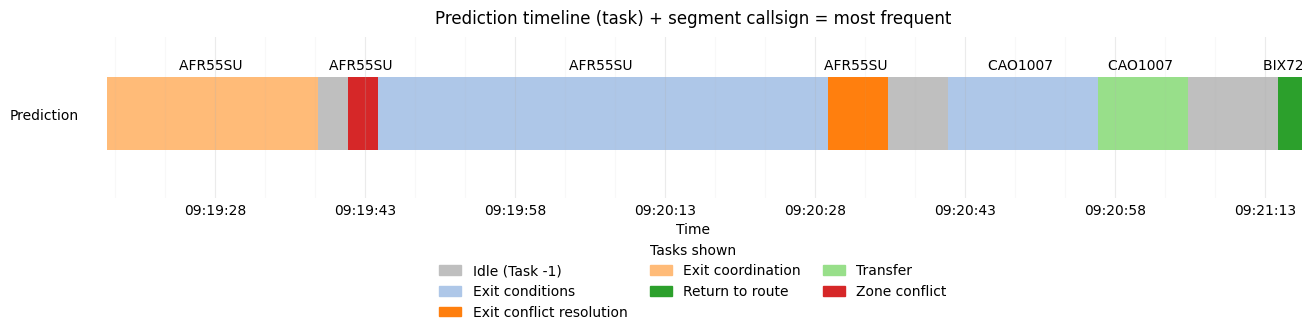

In [ ]:
# This associate a callsign based on the one that is the most present within the identified task segment
# Probably not optimal, especially in cases were one task segment might be associated for two callsigns (e.g. 2 transfers in a row), even though I'm not sure ATCO aggregated the labels when self-assessment. 


def _build_segments_idx(t_num: np.ndarray, y: np.ndarray):
    """
    Build contiguous segments in index space.
    Returns list of (start_i, end_i, start_num, dur_num, task_id)
    where [start_i:end_i] are the rows belonging to the segment.
    """
    if len(t_num) == 0:
        return []

    order = np.argsort(t_num)
    t_num = t_num[order]
    y = y[order]
    idx_order = order

    segs = []
    start_pos = 0
    cur = y[0]

    for pos in range(1, len(t_num)):
        if y[pos] != cur:
            s_pos, e_pos = start_pos, pos
            start = t_num[s_pos]
            end = t_num[e_pos]
            dur = max(0.0, end - start)

            segs.append((idx_order[s_pos], idx_order[e_pos-1], start, dur, int(cur)))
            start_pos = pos
            cur = y[pos]

    # last segment end: use median step
    step = float(np.median(np.diff(t_num))) if len(t_num) >= 2 else 0.0
    s_pos = start_pos
    start = t_num[s_pos]
    dur = step
    segs.append((idx_order[s_pos], idx_order[len(t_num)-1], start, dur, int(cur)))

    # Note: first two fields are *original* row indices of segment start/end
    return segs


def _mode_callsign(series: pd.Series):
    """Return most frequent non-null callsign, or None."""
    s = series.dropna().astype(str)
    if s.empty:
        return None
    # mode() can return multiple values; take the first deterministically
    return s.mode().iloc[0]


def plot_pred_task_with_segment_callsign(
    df: pd.DataFrame,
    time_col: str = "timestamp",
    pred_col: str = "pred_task",
    callsign_col: str = "callsign",
    title: str = "Prediction timeline with segment callsign (mode)",
    figsize=(13, 3.2),
    legend_max_items: int = 20,
    min_label_width_s: float = 2.0,   # only label segments wider than this
):
    d = df[[time_col, pred_col, callsign_col]].copy()
    d[time_col] = pd.to_datetime(d[time_col])
    d = d.sort_values(time_col).reset_index(drop=True)

    # matplotlib date numbers
    t_num = mdates.date2num(d[time_col].dt.to_pydatetime())
    y_pred = d[pred_col].astype(int).to_numpy()

    # colors
    present_ids = sorted(set(y_pred.tolist()))
    base_cmap = plt.get_cmap("tab20", 20)

    ordered_ids = [-1] + [i for i in range(0, 14) if i in present_ids]
    ordered_ids += [i for i in present_ids if i not in ordered_ids]

    task_to_color = {}
    for i, tid in enumerate(ordered_ids):
        task_to_color[tid] = (0.75, 0.75, 0.75, 1.0) if tid == -1 else base_cmap(i % 20)

    # segments in index space
    segs = _build_segments_idx(t_num, y_pred)

    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    # strip geometry
    strip_h = 0.45
    ymin = 0.30

    min_label_width_days = min_label_width_s / 86400.0

    for s_i, e_i, start, dur, tid in segs:
        ax.broken_barh(
            [(start, dur)],
            (ymin, strip_h),
            facecolors=task_to_color.get(tid, base_cmap(0)),
            edgecolors="none",
        )

        # callsign label per segment (skip idle)
        if tid != -1 and dur >= min_label_width_days:
            seg_callsign = _mode_callsign(d.loc[s_i:e_i, callsign_col])

            if seg_callsign is not None:
                x_center = start + dur / 2
                # put label just above the bar
                ax.text(
                    x_center,
                    ymin + strip_h + 0.03,
                    seg_callsign,
                    ha="center",
                    va="bottom",
                    fontsize=10,
                    clip_on=True,
                )

    # axes formatting
    ax.set_ylim(0, 1.0)
    ax.set_yticks([ymin + strip_h / 2])
    ax.set_yticklabels(["Prediction"])

    ax.set_title(title, pad=10)
    ax.set_xlabel("Time")

    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=15))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    ax.xaxis.set_minor_locator(mdates.SecondLocator(interval=5))
    ax.grid(True, axis="x", which="major", alpha=0.25)
    ax.grid(True, axis="x", which="minor", alpha=0.08)
    ax.grid(False, axis="y")

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(axis="both", which="both", length=0)

    if len(t_num) > 0:
        pad = (t_num.max() - t_num.min()) * 0.02 if t_num.max() > t_num.min() else 1 / 86400
        ax.set_xlim(t_num.min() - pad, t_num.max() + pad)

    # legend
    legend_ids = [-1] + [i for i in range(0, 14) if i in present_ids]
    legend_ids = [i for i in legend_ids if i in present_ids][:legend_max_items]

    handles = [
        mpatches.Patch(color=task_to_color[tid], label=_id_to_label.get(tid, f"Task {tid}"))
        for tid in legend_ids
    ]
    ax.legend(
        handles=handles,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.20),
        ncol=3,
        frameon=False,
        title="Tasks shown",
        handlelength=1.6,
        columnspacing=1.6,
    )

    return fig, ax

fig, ax = plot_pred_task_with_segment_callsign(
    task_type_instance,
    title="Prediction timeline task instance",
    min_label_width_s=2.0,
)
plt.show()

# Cherry Picking best two minutes task prediction

In [193]:
import pandas as pd

def best_2min_window_by_correct_active(
    df: pd.DataFrame,
    ts_col="prediction_epoch_ms",
    pred_col="pred_task",
    true_col="true_task",
    idle=-1,
    window_ms=2*60*1000,
    min_active: int = 10,         
    acc_tiebreak: float = 0.3,     
):
    d_all = df.copy().sort_values(ts_col).reset_index(drop=True)

    d_score = d_all[d_all[true_col] != idle].copy().reset_index(drop=True)
    if d_score.empty:
        return None, None

    d_score["correct"] = (d_score[pred_col] == d_score[true_col]).astype(int)

    t = d_score[ts_col].to_numpy()
    c = d_score["correct"].to_numpy()

    best = {"correct": -1, "acc": -1.0, "start": None, "end": None, "n": 0}
    j = 0
    running_correct = 0

    for i in range(len(d_score)):
        while j < len(d_score) and t[j] < t[i] + window_ms:
            running_correct += c[j]
            j += 1

        n = j - i
        if n >= min_active:
            acc = running_correct / n
            if acc >= acc_tiebreak:
                # primary: maximize correct; secondary: maximize accuracy; then maximize n
                if (running_correct > best["correct"]) or \
                   (running_correct == best["correct"] and acc > best["acc"]) or \
                   (running_correct == best["correct"] and acc == best["acc"] and n > best["n"]):
                    best.update({
                        "correct": int(running_correct),
                        "acc": float(acc),
                        "start": int(t[i]),
                        "end": int(t[i] + window_ms),
                        "n": int(n),
                    })

        running_correct -= c[i]

    if best["start"] is None:
        return None, None  # no window met min_active / acc_tiebreak

    best_window_rows = d_all[(d_all[ts_col] >= best["start"]) & (d_all[ts_col] < best["end"])].copy()

    summary = pd.DataFrame([{
        "window_start_epoch_ms": best["start"],
        "window_end_epoch_ms": best["end"],
        "n_active_scored": best["n"],
        "n_active_correct": best["correct"],
        "active_accuracy": best["acc"],
        "n_rows_total_in_window": len(best_window_rows),
    }])

    return summary, best_window_rows

summary, best_window_rows = best_2min_window_by_correct_active(out)
print(summary)

   window_start_epoch_ms  window_end_epoch_ms  n_active_scored  \
0          1758705557261        1758705677261               31   

   n_active_correct  active_accuracy  n_rows_total_in_window  
0                30         0.967742                      40  


In [194]:
best_window_rows

,id,prediction_epoch_ms,pred_task,true_task,pred_proba
1007,003_3_8_5,1758705557261,8,8,0.452041
1008,003_3_8_6,1758705560261,8,8,0.644427
1009,003_3_8_7,1758705563262,8,8,0.772642
1010,003_3_8_8,1758705566263,8,8,0.578119
1011,003_3_8_9,1758705569263,8,8,0.617782
1012,003_3_8_10,1758705572263,8,8,0.572570
1013,003_3_8_11,1758705575263,8,8,0.595620
1014,003_3_-1_682,1758705578264,-1,-1,0.331468
1015,003_3_-1_683,1758705581265,13,-1,0.246872
1016,003_3_-1_684,1758705584265,6,-1,0.388490


# Cherry picked 2-minute slots:
- ATCO001 - Scenario 3: 1758889892503 - 1758890009515 (accuracy: 0.56 - 17 active correct) very diverse
- ATCO001 - Scenario 1: 1758700993572 - 1758701110584 (accuracy: 0.78 - 7 active correct)
- ATCO002 - Scenario 2: 1757489247109 - 1757489364112 (accuracy: 0.73 - 11 active correct)
- ATCO002 - Scenario 3: 1757600815852 - 1757600932860 (accuracy: 0.81 - 9 active correct)
- ATCO003 - Scenario 1: 1758784318946 - 1758784435959 (accuracy: 0.91 - 21 active correct) very interesting as well
- ATCO003 - Scenario 3: 1758705557261 - 1758705674282 (accuracy: 0.97 - 30 active correct) very interesting
- ATCO004 - Scenario 1: 1757493758065 - 1757493875102 (accuracy: 0.79 - 19 active correct)
- ATCO004 - Scenario 2: 1757689424621 - 1757689544607 (accuracy: 0.94 - 16 active correct) very interesting